In [1]:
import os
os.chdir('/home/dgotzens/scripts/')

from torch.fft import fft,ifft,fftshift,ifftshift
import matplotlib.pyplot as plt
import tools, torch
import numpy as np


# Backprojection

In [50]:
import timedataparser
header,_,realdata,_,params = timedataparser.load_all('/home/dgotzens/recording/23-11-20/', loadfeparams=True)

M,K,L = (1024,192,1)
X,Y,Z = (512,3,256)
I = X*Y*Z
c0 = 299_792_458
β = params['RampSlope']
ω0 = 2*torch.pi*header['RampLowFrequency']
π = torch.pi


fs = 22e6
Ts = 1/fs

rmax = 6
rx = torch.linspace(-rmax, rmax, X)[:,None,None].expand((X,Y,Z))
ry = torch.linspace(-0.1*rmax, 0.1*rmax, Y)[None,:,None].expand((X,Y,Z))
rz = torch.linspace(0,rmax,Z)[None,None,:].expand((X,Y,Z))

data = torch.zeros((M,K,L),dtype=torch.cfloat)

# data[:,:,0] = torch.exp(-0.44j*torch.arange(M)).unsqueeze(-1)

loaded data with shape torch.Size([1022, 192, 9])


Target at $r_0=3.5m$
 
Ramp slope $\beta = 66GHz/s$
 
Sample rate $f_s = 22MHz$
 
$x_0 (t) \sim e^{-j2\pi \beta \frac{2r_0}{c_0} t} =: e^{-j\Omega m}$
 
$\Rightarrow \Omega = 0.440 $



$2\pi \beta \frac{2r_0}{c_0f_s} \approx 0.471$
$\Rightarrow r_0 = 0.471 \frac{c_0f_s}{4 \pi \beta} = 3.748m$

In [54]:
# calculate runtimes
dist = torch.empty((K,X,Y,Z))
for k in range(K):
    dist[k,...] =  ((params['txPosX'][k] - rx)**2 + abs(params['txPosY'][k] - ry)**2 + rz**2).sqrt()\
                 + ((params['rxPosX'][k] - rx)**2 + abs(params['rxPosY'][k] - ry)**2 + rz**2).sqrt()
    
tau = lambda x,y,z : dist[:,(rx[:,0,0]-x).abs().argmin(), \
                            (ry[0,:,0]-y).abs().argmin(), \
                            (rz[0,0,:]-z).abs().argmin()]/c0
point = lambda x,y,z : torch.exp(-1j*(ω0 + 0.5*β*tau(x,y,z)) * tau(x,y,z))\
                       *  torch.exp(-2j*π*β * tau(x,y,z) * torch.arange(M).unsqueeze(-1)*Ts)
data[:,:,0] = point(3,0,4) + point(0,0,5) + point(-4,0,3)

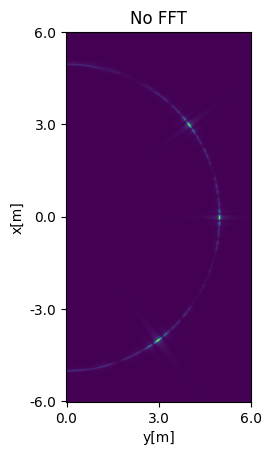

In [82]:
img = torch.zeros((X,Z), dtype=torch.cfloat)
for k in range(K):
    τ = dist[k,:,Y//2,:]/c0
    exp = torch.exp(2j*π*β*τ*torch.arange(M)[:,None,None]*Ts)
    g = torch.exp(-1j*(ω0 + 0.5*β*τ) * τ)
    img += g.conj() * torch.mean(exp*data[:,k,0,None,None], dim=0)

plt.imshow(img.abs()/K, origin='lower')
plt.yticks(range(0,X+1,X//4), [rmax/2*i for i in range(-2,2+1)])
plt.xticks(range(0,Z+1,Z//2), [rmax/2*i for i in range(2+1)])
plt.ylabel('x[m]')
plt.xlabel('y[m]')
# plt.grid()
plt.title('No FFT')
plt.show()

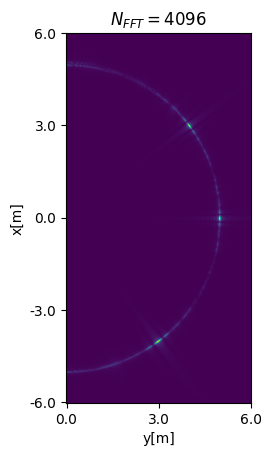

In [78]:
nfft = data.shape[0]
# plt.plot(ifft(data[:,0,0]).abs())
# plt.plot(ifft(data[:,0,0]).angle())
# plt.xticks([nfft/10*i for i in range(11)], [25/10*i for i in range(11)])
# plt.show()
nfft = 1024*4
img_fft = torch.zeros((X,Z),dtype=torch.cfloat)
# window = torch.hann_window(M)
# window = torch.hamming_window(M)
window = torch.ones(M)

for k in range(K):
    index = (β*dist[k,:,Y//2,:]/(c0*fs)*nfft).flatten(0)
    g = torch.exp(-1j*ω0*dist[k,:,Y//2,:]/c0 + 1j*β*dist[k,:,Y//2,:]**2/c0**2)
    # interpolate
    idft = ifft(window*data[:,k,0], n=nfft).log()
    t = index - index.floor()
    interpol = t*idft[index.floor().long()] + (1-t)*idft[index.ceil().long()]
    
    # img_fft += g.conj() * torch.exp(interpol).unflatten(0,(X,Z))
    img_fft += g.conj() * ifft(window*data[:,k,0], n=nfft)[index.long()].unflatten(0,(X,Z))


plt.imshow(img_fft.abs()/K, origin='lower')
plt.yticks(range(0,X+1,X//4), [rmax/2*i for i in range(-2,2+1)])
plt.xticks(range(0,Z+1,Z//2), [rmax/2*i for i in range(2+1)])
plt.ylabel('x[m]')
plt.xlabel('y[m]')
# plt.grid()
plt.title(r'$N_{FFT}=$' + f'{nfft}')
plt.show()

torch.Size([192])


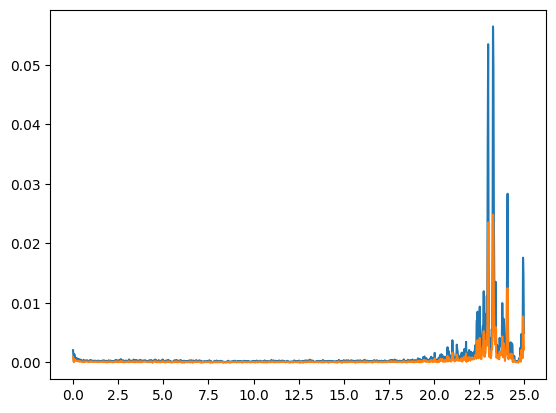

/tmp/ipykernel_3173075/885197966.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


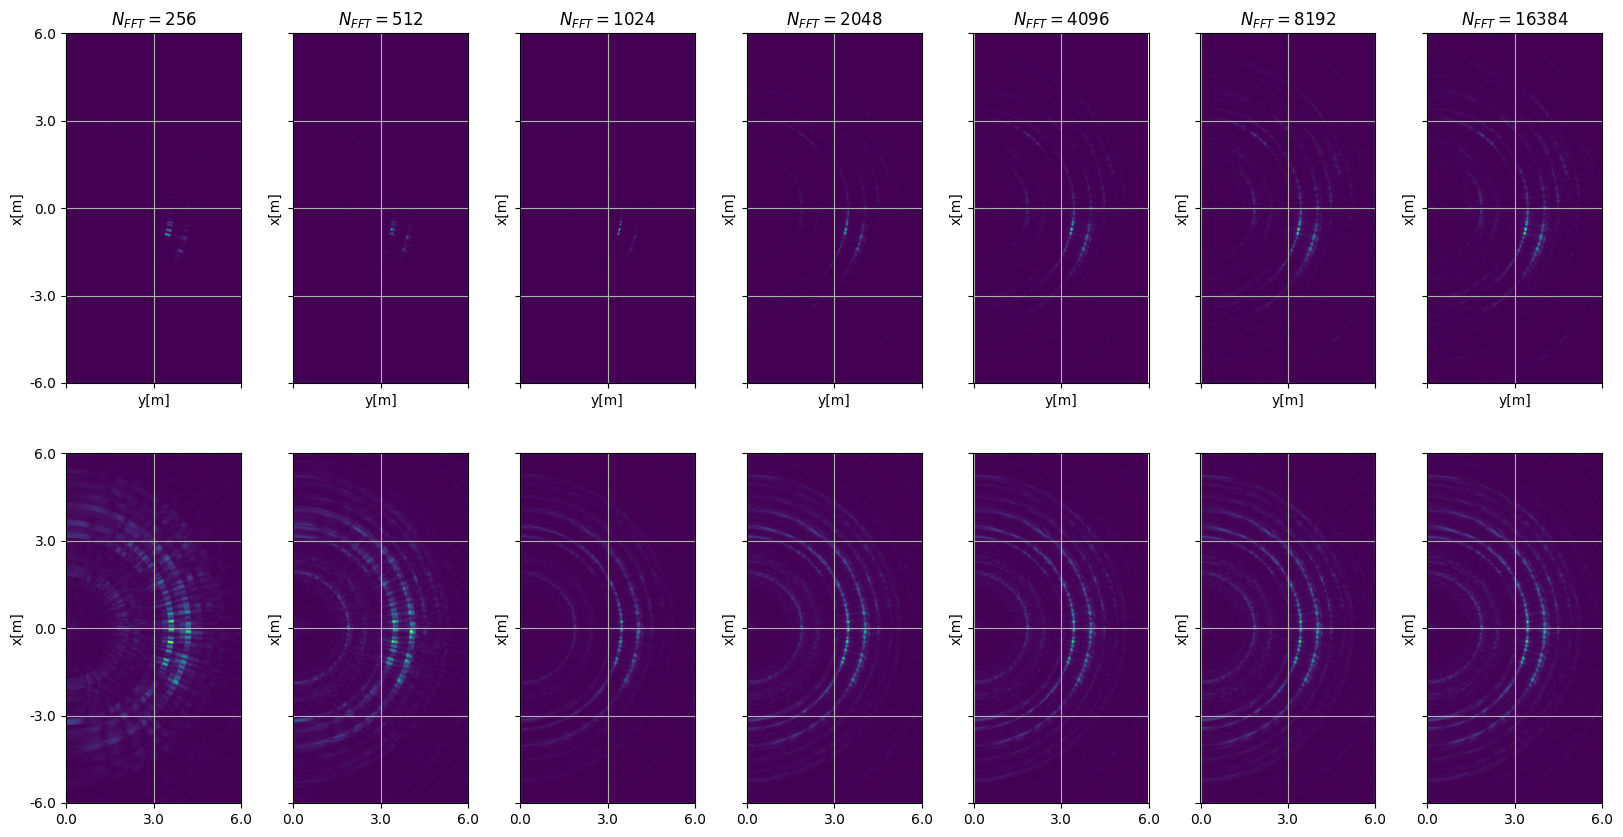

In [66]:
nfft = 1022

rangedata = fft(realdata[:,:,0], n=nfft, dim=0)
search_idx = torch.tensor([m for m,r in enumerate(tools.ranges(header, nfft)) if 3<r<3.8])
m_refl = tools.reflidx(rangedata.mean(1), search_idx)
weight = rangedata[m_refl,:]
print(weight.shape)
calibrated = ifft(rangedata/weight.conj(), n=nfft, dim=0)

plt.plot(ifft(realdata[:,0,0]).abs())
plt.plot(ifft(-calibrated[:,0]).abs())
plt.xticks([nfft/10*i for i in range(11)], [25/10*i for i in range(11)])
plt.show()

f,ax = plt.subplots(2,7,sharex=True,sharey=True)
f.set_figwidth(20)
f.set_figheight(10)
for n in range(7):
    nfft = 256*2**n
    img_fft = torch.zeros((X,Z),dtype=torch.cfloat)
    img_fft_calib = torch.zeros((X,Z),dtype=torch.cfloat)
    # window = torch.hann_window(M)
    # window = torch.hamming_window(M)
    # window = torch.ones(calibrated.shape[0])
    for k in range(K):
        index = (β*dist[k,:,Y//2,:]/(c0*fs)*nfft).flatten(0)
        g = torch.exp(1j*ω0*dist[k,:,Y//2,:]/c0)

        img_fft += g * ifft(realdata.conj()[:,k,0], n=nfft)[index.long()].unflatten(0,(X,Z))
        img_fft_calib += g * ifft(calibrated.conj()[:,k], n=nfft)[index.long()].unflatten(0,(X,Z))

    ax[0,n].imshow(img_fft.abs().exp()/K, origin='lower')
    ax[1,n].imshow(img_fft_calib.abs().exp()/K, origin='lower')
    ax[0,n].set_yticks(range(0,X+1,X//4), [rmax/2*i for i in range(-2,2+1)])
    ax[1,n].set_yticks(range(0,X+1,X//4), [rmax/2*i for i in range(-2,2+1)])
    ax[1,n].set_xticks(range(0,Z+1,Z//2), [rmax/2*i for i in range(2+1)])
    ax[0,n].set_ylabel('x[m]')
    ax[1,n].set_ylabel('x[m]')
    ax[0,n].set_xlabel('y[m]')
    ax[0,n].grid()
    ax[1,n].grid()
    ax[0,n].set_title(r'$N_{FFT}=$' + f'{nfft}')
f.show()

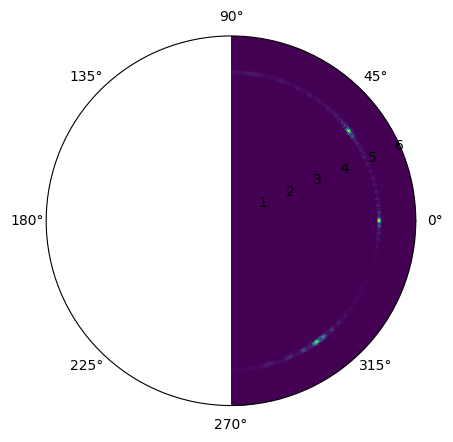

In [81]:
ula_idx = tools.ula_idx(header)
# window = torch.hamming_window(len(ula_idx))
# window = torch.hann_window(len(ula_idx))
window = torch.ones(len(ula_idx))
nfft = 1024
rangedata = tools.rangedata(data.conj(), nfft)/nfft
n_azm = 512
azimuth = ifftshift(fft(fftshift(window*rangedata[:,ula_idx,0]), dim=1, n=n_azm))

theta = -torch.asin(2*torch.arange(n_azm+1)/n_azm - 1)
M_max = nfft//8
R = 25/nfft * torch.arange(M_max+1)*2

f,ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.pcolormesh(theta,R,azimuth[0:M_max, :].abs())
ax.grid(False)
